# Logistic Regression Analysis of Sales Outcome

This notebook performs a logistic regression analysis to predict sales outcomes based on various variables extracted from sales transcripts. We'll follow a systematic workflow that includes data preparation, addressing multicollinearity, variable selection, model evaluation, and interpretation.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Data Preprocessing](#data-preprocessing)
5. [Initial Model Fitting](#initial-model-fitting)
6. [Multicollinearity Check](#multicollinearity-check)
7. [Variable Selection](#variable-selection)
8. [Model Evaluation](#model-evaluation)
9. [Model Interpretation](#model-interpretation)
10. [Conclusion](#conclusion)


In [1]:
! pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels imbalanced-learn > /dev/null 2>&1


The system cannot find the path specified.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE

# Modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.feature_selection import RFE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
pd.set_option('display.max_columns', None)


<a id='introduction'></a>
## 1. Introduction

The goal of this analysis is to build a logistic regression model that predicts whether a sales outcome is a win or a loss based on various features extracted from sales call transcripts.

**Variables to be analyzed:**

- **Speech Features:**
  - `total_duration`, `ae_talk_ratio`, `no_talk_ratio_duration`, etc.
- **Question Metrics:**
  - `ae_total_questions`, `ae_question_ratio`, `client_total_questions`, etc.
- **Sentiment and Emotion Metrics:**
  - `sentiment_score`, `emotional_intensity_score`, `anger`, `joy`, etc.

We'll follow these steps:

1. Load and prepare the data.
2. Explore the data and perform initial analysis.
3. Preprocess the data (handle missing values, encode categorical variables, scale features, address class imbalance).
4. Fit an initial logistic regression model with all variables.
5. Check for multicollinearity using Variance Inflation Factor (VIF).
6. Address multicollinearity by removing or combining variables or using regularization techniques.
7. Perform feature selection to identify the most significant predictors.
8. Evaluate the final model's performance.
9. Interpret the model coefficients and provide insights.


In [3]:
# For reproducibility
np.random.seed(42)


<a id='data-loading-and-preparation'></a>
## 2. Data Loading and Preparation

We'll start by loading the dataset from a CSV file and preparing it for analysis.


In [4]:
# Load the dataset
all_transcripts_df = pd.read_csv('transcript_dfs/all_transcripts_df.csv')

# Remove duplicate records based on the 'id' column
all_transcripts_df.drop_duplicates(subset='id', inplace=True)

# Display the first few rows
all_transcripts_df.head()


,id,title,ae_name,ae_email,sales_outcome,date,meeting_attendees,host_email,transcript_url,video_url,audio_url,total_duration,ae_talk_duration,client_talk_duration,no_talk_duration,ae_talk_ratio,client_talk_ratio,ae_talk_ratio_duration,client_talk_ratio_duration,no_talk_ratio_duration,ae_total_questions,ae_question_ratio,ae_questions_per_minute,ae_first_question_timing_seconds,ae_entropy,ae_gini_coefficient,ae_ave_time_between_questions_seconds,ae_questions_per_segment,client_total_questions,client_question_ratio,client_questions_per_minute,client_first_question_timing_seconds,client_entropy,client_gini_coefficient,client_ave_time_between_questions_seconds,client_questions_per_segment,sentiment_score,emotional_intensity_score,anger,disgust,fear,joy,sadness,surprise,sentiment_balance_ratio,ae_sentiment,client_sentiment,ae_sentiment_variability,client_sentiment_variability,ae_sentiment_trend,client_sentiment_trend,emotional_reciprocity
0,FxuRiyttDW782zH3,Greg <> My Amazon Guy,Shawn Henderson,shawn.henderson@myamazonguy.com,closed_lost,2023/09/19,"sales@motomfg.com, shawn.henderson@myamazonguy...",albert.lapuz@myamazonguy.com,https://app.fireflies.ai/view/FxuRiyttDW782zH3,https://cdn.fireflies.ai/FxuRiyttDW782zH3/vide...,https://cdn.fireflies.ai/FxuRiyttDW782zH3/audi...,3684.41,2543.468,767.444,373.498,0.768208,0.231792,0.690333,0.208295,0.101373,54,0.79,0.88,13.16,0.917867,0.325926,69.15,"8, 1, 12, 1, 5, 5, 3, 6, 5, 8",12,0.21,0.20,15.32,0.878495,0.333333,324.40,"1, 1, 2, 0, 1, 2, 0, 2, 1, 2",0.127632,0.168270,0.019343,0.029039,0.008693,0.037537,0.018408,0.055250,0.955511,0.041697,0.009316,0.368851,0.414361,-0.000135,0.000305,0.088540
1,I7fHBY3mXdH0p1z6,"EPE INDUSTRIES USA, INC. - David <> My Amazon Guy",John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/21,"christene.mendoza@myamazonguy.com, john.aspina...",christene.mendoza@myamazonguy.com,https://app.fireflies.ai/view/I7fHBY3mXdH0p1z6,https://cdn.fireflies.ai/I7fHBY3mXdH0p1z6/vide...,https://cdn.fireflies.ai/I7fHBY3mXdH0p1z6/audi...,941.32,730.572,146.076,64.672,0.833370,0.166630,0.776114,0.155182,0.068704,29,0.97,1.85,2.83,0.881969,0.382759,30.77,"2, 2, 7, 6, 3, 4, 0, 2, 2, 1",3,0.03,0.19,5.88,0.477121,0.700000,405.13,"1, 0, 0, 0, 0, 1, 0, 0, 1, 0",0.013949,0.201851,0.032581,0.065411,0.007686,0.030010,0.017538,0.048625,0.564766,0.003723,0.047967,0.412839,0.294253,-0.000073,-0.000296,0.274073
2,ZFxjWW0HNgH9LwNW,Marieke <> My Amazon Guy,John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/21,"marieke@pinkgellac.com, john.aspinall@myamazon...",john.aspinall@myamazonguy.com,https://app.fireflies.ai/view/ZFxjWW0HNgH9LwNW,https://cdn.fireflies.ai/ZFxjWW0HNgH9LwNW/vide...,https://cdn.fireflies.ai/ZFxjWW0HNgH9LwNW/audi...,2007.57,1450.142,410.064,147.364,0.779560,0.220440,0.722337,0.204259,0.073404,60,0.89,1.79,47.30,0.934987,0.300000,32.29,"2, 10, 5, 11, 4, 11, 2, 6, 4, 5",15,0.11,0.45,148.74,0.864831,0.380000,115.58,"3, 2, 2, 1, 2, 1, 0, 3, 1, 0",0.023343,0.196026,0.028274,0.047890,0.009162,0.029954,0.018106,0.062640,0.504200,0.004530,0.024980,0.380418,0.445578,0.000042,0.000056,0.078420
3,jRxXxp3oAK2sJ4S9,Charles <> My Amazon Guy,John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/22,"charles@rushdirect.net, john.aspinall@myamazon...",john.aspinall@myamazonguy.com,https://app.fireflies.ai/view/jRxXxp3oAK2sJ4S9,https://cdn.fireflies.ai/jRxXxp3oAK2sJ4S9/vide...,https://cdn.fireflies.ai/jRxXxp3oAK2sJ4S9/audi...,1363.86,1190.402,65.352,108.106,0.947958,0.052042,0.872818,0.047917,0.079265,61,0.92,2.68,1.32,0.878401,0.388525,22.09,"4, 1, 0, 3, 6, 10, 9, 7, 15, 6",3,0.08,0.13,299.13,0.477121,0.700000,334.39,"0, 0, 1, 0, 0, 0, 1, 1, 0, 0",-0.016583,0.235935,0.027916,0.078852,0.013298,0.018956,0.018264,0.078648,0.430466,0.002718,-0.008349,0.377271,0.237748,-0.000348,0.000395,-0.275404
4,h1A61pzi1I8uhJHh,Hannah <> My Amazon Guy,Matt Lopez,matt.lopez@myamazonguy.com,closed_lost,2023/09/18,"matt.lopez@myamazonguy.com, hannahamyanderson@...",matt.lopez@myama

**Note:** The dataset is assumed to be loaded successfully. The DataFrame `all_transcripts_df` contains all the necessary variables for analysis.


In [5]:
# Check the shape of the DataFrame
print(f"The dataset contains {all_transcripts_df.shape[0]} rows and {all_transcripts_df.shape[1]} columns.")


The dataset contains 2595 rows and 52 columns.


### Creating the Binary Outcome Variable

We need to create a binary variable `sales_outcome_binary` where:

- `1` represents a **won** sale.
- `0` represents a **lost** sale.


In [6]:
# Map 'sales_outcome' to binary values
all_transcripts_df['sales_outcome_binary'] = all_transcripts_df['sales_outcome'].map({
    'closed_won': 1,
    'closed_lost': 0
})

# Drop rows with missing sales outcome
all_transcripts_df.dropna(subset=['sales_outcome_binary'], inplace=True)

# Verify the mapping
all_transcripts_df['sales_outcome_binary'].value_counts()


0    1945
1     650
Name: sales_outcome_binary, dtype: int64

### Selecting the Variables for Analysis

We'll focus on the variables specified earlier.


In [7]:
# List of variables to analyze
variables = [
    'total_duration', 'ae_talk_ratio', 'no_talk_ratio_duration', 'ae_questions_per_minute',
  	'ae_first_question_timing_seconds', 'ae_entropy', 'ae_ave_time_between_questions_seconds',
  	'client_questions_per_minute', 'client_first_question_timing_seconds', 'client_entropy',
    'client_ave_time_between_questions_seconds', 'sentiment_score', 'anger', 'disgust',
    'fear', 'joy', 'sadness', 'surprise', 'ae_sentiment', 'client_sentiment',
  	'ae_sentiment_variability', 'client_sentiment_variability', 'ae_sentiment_trend',
  	'client_sentiment_trend', 'emotional_reciprocity'
]

# Ensure all variables are present in the DataFrame
variables = [var for var in variables if var in all_transcripts_df.columns]

print(f"Number of variables for analysis: {len(variables)}")


Number of variables for analysis: 25


<a id='exploratory-data-analysis'></a>
## 3. Exploratory Data Analysis

Before modeling, it's essential to understand the data distribution, identify missing values, detect any anomalies, and check for class imbalance.


In [8]:
# Summary statistics
all_transcripts_df[variables + ['sales_outcome_binary']].describe()


,total_duration,ae_talk_ratio,no_talk_ratio_duration,ae_questions_per_minute,ae_first_question_timing_seconds,ae_entropy,ae_ave_time_between_questions_seconds,client_questions_per_minute,client_first_question_timing_seconds,client_entropy,client_ave_time_between_questions_seconds,sentiment_score,anger,disgust,fear,joy,sadness,surprise,ae_sentiment,client_sentiment,ae_sentiment_variability,client_sentiment_variability,ae_sentiment_trend,client_sentiment_trend,emotional_reciprocity,sales_outcome_binary
count,2595.000000,2595.000000,2595.000000,2595.000000,2365.000000,2365.000000,2330.000000,2595.000000,2298.000000,2298.000000,2235.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2592.000000,2595.000000
mean,1825.618836,0.606788,0.150782,0.886085,41.052655,0.791097,78.965966,0.464613,145.930418,0.690526,149.630313,0.076301,0.031381,0.043176,0.013390,0.047714,0.025315,0.070362,0.032624,0.039489,0.335982,0.357875,0.000228,-0.000457,0.103252,0.250482
std,1104.613129,0.247026,0.168546,0.823858,92.445411,0.188367,56.962598,0.408097,250.761618,0.213501,125.414693,0.105872,0.033884,0.028295,0.024421,0.040576,0.023913,0.037999,0.030597,0.219047,0.109146,0.133078,0.042773,0.020239,0.121568,0.433374
min,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.440000,-0.782140,0.002899,0.002009,0.001183,0.002275,0.003014,0.002911,-0.369169,-0.792439,0.000000,0.000000,-1.015891,-0.677559,-0.998520,0.000000
25%,1019.255000,0.519825,0.078987,0.490000,0.590000,0.729948,45.620000,0.220000,3.515000,0.587072,79.930000,0.027680,0.021163,0.028452,0.007622,0.031606,0.016470,0.055829,0.016553,0.003736,0.320001,0.336536,-0.000166,0.000000,0.000000,0.000000
50%,1769.136000,0.655622,0.102024,0.820000,4.890000,0.851259,63.760000,0.390000,35.450000,0.746915,119.000000,0.078731,0.026687,0.038342,0.010201,0.042699,0.020683,0.066326,0.031814,0.020670,0.365949,0.393508,0.000000,0.000169,0.092283,0.000000
75%,2569.652000,0.755346,0.138383,1.150000,32.240000,0.915038,93.237500,0.620000,189.205000,0.844300,180.755000,0.125967,0.033700,0.050818,0.014383,0.054409,0.027151,0.078132,0.045843,0.040352,0.395182,0.436367,0.000189,0.000545,0.175901,1.000000
max,10205.200000,1.000000,0.997141,21.540000,1182.240000,0.994034,907.340000,6.520000,3249.780000,0.992017,1886.980000,0.953028,0.829375,0.564967,0.773737,0.813123,0.601632,0.870939,0.491005,6.274217,0.783597,0.636044,1.458988,0.190267,0.672020,1.000000


In [9]:
# Check for missing values
missing_values = all_transcripts_df[variables].isnull().sum().sort_values(ascending=False)
print("Missing values in each variable:")
print(missing_values[missing_values > 0])


Missing values in each variable:
client_ave_time_between_questions_seconds    360
client_first_question_timing_seconds         297
client_entropy                               297
ae_ave_time_between_questions_seconds        265
ae_first_question_timing_seconds             230
ae_entropy                                   230
emotional_reciprocity                          3
dtype: int64


### Handling Missing Values

We'll need to handle missing values appropriately. For simplicity, we'll proceed by dropping rows with missing values in the selected variables.


In [10]:
# Drop rows with missing values in the selected variables
all_transcripts_df.dropna(subset=variables, inplace=True)

# Verify that there are no missing values
print("Missing values after dropping:")
print(all_transcripts_df[variables].isnull().sum().sum())


Missing values after dropping:
0


### Handling Mishandled Transcripts

We'll also check for any transcripts that were mishandled during data collection and remove them from the analysis.

Theses transcripts can be identified by checking the `ae_talk_ratio`. If the ratio is `0` or `1`, it indicates that the speakers were not correctly identified.

In [11]:
# Identify mishandled transcripts
mishandled_transcripts = all_transcripts_df[
    (all_transcripts_df['ae_talk_ratio'] == 0) | (all_transcripts_df['ae_talk_ratio'] == 1)
]

print(f"Number of mishandled transcripts: {len(mishandled_transcripts)}")

# Remove mishandled transcripts from the dataset
all_transcripts_df = all_transcripts_df[
    (all_transcripts_df['ae_talk_ratio'] != 0) & (all_transcripts_df['ae_talk_ratio'] != 1)
]

print(f"Number of transcripts after removing mishandled ones: {len(all_transcripts_df)}")


Number of mishandled transcripts: 50
Number of transcripts after removing mishandled ones: 2119


### Checking Class Balance

We'll check the distribution of the target variable to see if there's any class imbalance.


In [12]:
# Check the distribution of the target variable
print("Distribution of the target variable in the dataset:")
print(all_transcripts_df['sales_outcome_binary'].value_counts())


Distribution of the target variable in the dataset:
0    1551
1     568
Name: sales_outcome_binary, dtype: int64


<a id='data-preprocessing'></a>
## 4. Data Preprocessing

### Splitting the Data

We'll split the data into features (`X`) and target (`y`).


In [13]:
# Features and target
X = all_transcripts_df[variables]
y = all_transcripts_df['sales_outcome_binary']


### Standardizing the Features

Logistic regression can benefit from feature scaling, especially when regularization is used.


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled = pd.DataFrame(X_scaled, columns=variables)


### Splitting into Training and Test Sets

We'll split the data into training and test sets to evaluate the model's performance on unseen data.


In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 1695 samples
Test set size: 424 samples


### Addressing Class Imbalance with SMOTE

The dataset has an imbalanced target variable, which can affect the performance of the model. We'll use SMOTE (Synthetic Minority Oversampling Technique) to balance the classes in the training set.


In [16]:
# Check the distribution of the target variable in the training set
print("Distribution of the target variable in the training set:")
print(y_train.value_counts())

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Distribution of the target variable after applying SMOTE:")
print(y_train_smote.value_counts())


Distribution of the target variable in the training set:
0    1241
1     454
Name: sales_outcome_binary, dtype: int64
Distribution of the target variable after applying SMOTE:
1    1241
0    1241
Name: sales_outcome_binary, dtype: int64


<a id='initial-model-fitting'></a>
## 5. Initial Model Fitting

We'll fit an initial logistic regression model using all variables.


In [17]:
# Initialize the logistic regression model
log_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)

# Fit the model on the SMOTE-balanced training data
log_reg.fit(X_train_smote, y_train_smote)


LogisticRegression(max_iter=1000, penalty=None)

<a id='multicollinearity-check'></a>
## 6. Multicollinearity Check

Multicollinearity can inflate the variance of coefficient estimates and make the model unstable. We'll calculate the Variance Inflation Factor (VIF) for each feature.

**Note:** VIF is calculated on the original training data before SMOTE is applied.


In [18]:
# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data

# Calculate VIF on the original training set
vif_df = calculate_vif(X_train)

print("Variance Inflation Factor (VIF) for each feature:")
vif_df.sort_values('VIF', ascending=False)


Variance Inflation Factor (VIF) for each feature:


,Feature,VIF
11,sentiment_score,4.616100
3,ae_questions_per_minute,2.710796
15,joy,2.585577
13,disgust,2.578567
18,ae_sentiment,2.515739
9,client_entropy,2.514831
7,client_questions_per_minute,2.374141
0,total_duration,2.105741
19,client_sentiment,2.104326
5,ae_entropy,2.094763


### Addressing Multicollinearity

Variables with VIF values greater than 5 indicate potential multicollinearity issues. We'll consider removing these variables.


In [19]:
# Identify variables with VIF > 5
high_vif_features = vif_df[vif_df['VIF'] > 5]['Feature']
print("Features with VIF > 5:")
print(high_vif_features.tolist())


Features with VIF > 5:
[]


In [20]:
# Remove high VIF features
X_train_reduced = X_train.drop(columns=high_vif_features)
X_test_reduced = X_test.drop(columns=high_vif_features)

# Apply SMOTE to the reduced training data
X_train_reduced_smote, y_train_smote = smote.fit_resample(X_train_reduced, y_train)

# Recalculate VIF after removal
vif_df_reduced = calculate_vif(X_train_reduced)
print("VIF after removing high VIF features:")
vif_df_reduced.sort_values('VIF', ascending=False)


VIF after removing high VIF features:


,Feature,VIF
11,sentiment_score,4.616100
3,ae_questions_per_minute,2.710796
15,joy,2.585577
13,disgust,2.578567
18,ae_sentiment,2.515739
9,client_entropy,2.514831
7,client_questions_per_minute,2.374141
0,total_duration,2.105741
19,client_sentiment,2.104326
5,ae_entropy,2.094763


<a id='variable-selection'></a>
## 7. Variable Selection

To further refine the model, we'll perform feature selection using Lasso Regularization.

### Lasso Regularization


In [21]:
# Initialize logistic regression with L1 penalty
log_reg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Fit the model on the SMOTE-balanced reduced training data
log_reg_lasso.fit(X_train_reduced_smote, y_train_smote)

# Get the coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Coefficient': log_reg_lasso.coef_[0]
})

# Identify selected features
selected_features = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]['Feature'].tolist()
print(f"Selected {len(selected_features)} features using Lasso: {selected_features}")


Selected 25 features using Lasso: ['total_duration', 'ae_talk_ratio', 'no_talk_ratio_duration', 'ae_questions_per_minute', 'ae_first_question_timing_seconds', 'ae_entropy', 'ae_ave_time_between_questions_seconds', 'client_questions_per_minute', 'client_first_question_timing_seconds', 'client_entropy', 'client_ave_time_between_questions_seconds', 'sentiment_score', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'ae_sentiment', 'client_sentiment', 'ae_sentiment_variability', 'client_sentiment_variability', 'ae_sentiment_trend', 'client_sentiment_trend', 'emotional_reciprocity']


### Fitting the Final Model

We'll fit the logistic regression model using only the selected features.


In [22]:
# Subset the training and test sets
X_train_final = X_train_reduced[selected_features]
X_test_final = X_test_reduced[selected_features]

# Apply SMOTE to the final training data
X_train_final_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

# Initialize the logistic regression model with regularization
final_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Fit the final model
final_model.fit(X_train_final_smote, y_train_smote)


LogisticRegression(max_iter=1000)

<a id='model-evaluation'></a>
## 8. Model Evaluation

We'll evaluate the model's performance on the test set.


In [23]:
# Predict on the test set
y_pred = final_model.predict(X_test_final)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")


Test set accuracy: 0.6108


In [24]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.61      0.70       310
           1       0.37      0.62      0.46       114

    accuracy                           0.61       424
   macro avg       0.59      0.61      0.58       424
weighted avg       0.69      0.61      0.63       424



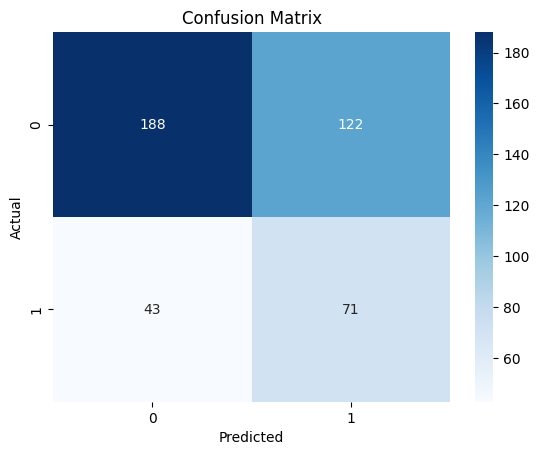

In [25]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ROC AUC Score: 0.6608


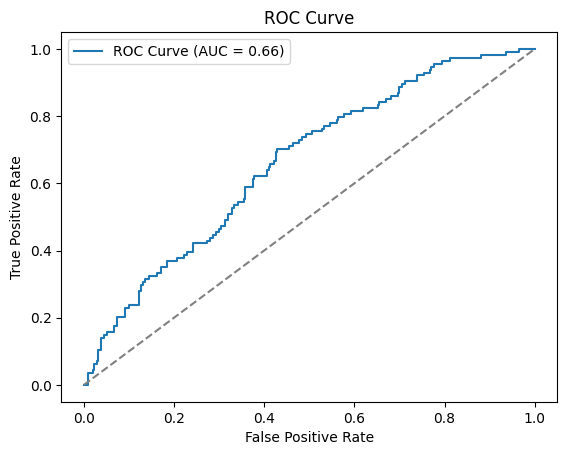

In [26]:
# ROC Curve and AUC
y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


<a id='model-interpretation'></a>
## 9. Model Interpretation

### Coefficient Analysis

We'll examine the coefficients of the final model to understand the impact of each feature.


In [27]:
# Recalculate VIFs for all features in the initial model
vif_df_initial = calculate_vif(X_train)

# Create a DataFrame for coefficients of the final model
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final_model.coef_[0]
})

# Calculate odds ratios for included features
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])

# Add a column to indicate that these features were included
coefficients['Included in Final Model'] = 'Yes'

# For features that were dropped, set coefficients and odds ratios to NaN
all_features = X_train.columns.tolist()
dropped_features = [feature for feature in all_features if feature not in selected_features]

# Create a DataFrame for dropped features
dropped_df = pd.DataFrame({
    'Feature': dropped_features,
    'Coefficient': [np.nan]*len(dropped_features),
    'Odds Ratio': [np.nan]*len(dropped_features),
    'Included in Final Model': 'No'
})

# Combine the coefficients of included and dropped features
all_features_df = pd.concat([coefficients, dropped_df], ignore_index=True)

# Merge with VIF values
# Rename VIF column for clarity
vif_df_initial.rename(columns={'VIF': 'VIF Score'}, inplace=True)

# Merge VIFs with all_features_df
all_features_df = all_features_df.merge(vif_df_initial[['Feature', 'VIF Score']], on='Feature', how='left')

# Sort the DataFrame for better readability
all_features_df.sort_values(by='Included in Final Model', ascending=False, inplace=True)

# Reset index
all_features_df.reset_index(drop=True, inplace=True)

# Display the final table
all_features_df[['Feature', 'Included in Final Model', 'Coefficient', 'Odds Ratio', 'VIF Score']]

all_features_df


,Feature,Coefficient,Odds Ratio,Included in Final Model,VIF Score
0,total_duration,0.366114,1.442120,Yes,2.105741
1,disgust,-0.320212,0.725995,Yes,2.578567
2,client_sentiment_trend,0.318067,1.374469,Yes,1.449564
3,ae_sentiment_trend,0.348442,1.416858,Yes,1.077463
4,client_sentiment_variability,-0.017546,0.982607,Yes,1.550591
5,ae_sentiment_variability,-0.069316,0.933031,Yes,1.808059
6,client_sentiment,0.161211,1.174933,Yes,2.104326
7,ae_sentiment,0.201483,1.223216,Yes,2.515739
8,surprise,-0.055389,0.946117,Yes,1.593392
9,sadness,-0.096344,0.908152,Yes,1.720326


### Coefficient Table with All Features

The table below includes all the features from the initial model, indicating whether they were included in the final model. Coefficients and odds ratios are shown for the features included in the final model. For dropped features, these values are marked as N/A. The VIF scores are provided for all features.

**Table: Coefficients, Odds Ratios, and VIF Scores**


In [28]:
# Display the table
display(all_features_df[['Feature', 'Included in Final Model', 'Coefficient', 'Odds Ratio', 'VIF Score']])


,Feature,Included in Final Model,Coefficient,Odds Ratio,VIF Score
0,total_duration,Yes,0.366114,1.442120,2.105741
1,disgust,Yes,-0.320212,0.725995,2.578567
2,client_sentiment_trend,Yes,0.318067,1.374469,1.449564
3,ae_sentiment_trend,Yes,0.348442,1.416858,1.077463
4,client_sentiment_variability,Yes,-0.017546,0.982607,1.550591
5,ae_sentiment_variability,Yes,-0.069316,0.933031,1.808059
6,client_sentiment,Yes,0.161211,1.174933,2.104326
7,ae_sentiment,Yes,0.201483,1.223216,2.515739
8,surprise,Yes,-0.055389,0.946117,1.593392
9,sadness,Yes,-0.096344,0.908152,1.720326


### **Interpretation**

Based on the model's performance and the coefficients obtained from the logistic regression, we can draw several insights:

#### **Model Performance:**

- **Test Set Accuracy:** The model achieved an accuracy of **61.08%** on the test set. This indicates that the model correctly predicts the sales outcome approximately 61% of the time.

- **ROC AUC Score:** The ROC AUC score is **0.6608**, suggesting a moderate ability of the model to distinguish between won and lost sales.

- **Classification Report & Confusion Matrix:**
  - **Precision and Recall:**
    - **Class 0 (Lost Sales):**
      - **Precision:** 0.81
      - **Recall:** 0.61
    - **Class 1 (Won Sales):**
      - **Precision:** 0.37
      - **Recall:** 0.62
  - **Confusion Matrix:**
    - **True Negatives (Correctly identified lost sales):** 188
    - **False Positives (Lost sales predicted as won):** 122
    - **False Negatives (Won sales predicted as lost):** 43
    - **True Positives (Correctly identified won sales):** 71

- **Interpretation:**
  - The model has higher precision for class `0` (lost sales) and higher recall for class `1` (won sales). This means the model is better at correctly identifying actual won sales but tends to misclassify some lost sales as won. The overall accuracy and ROC AUC score indicate moderate predictive performance.

#### **Coefficient Analysis:**

##### **Positive Coefficients (Increase Odds of Winning):**

1. **`total_duration` (0.3661):**
   - **Odds Ratio:** 1.4421
   - **Interpretation:** Longer call durations are associated with higher chances of winning a sale. Each standard deviation increase in call duration increases the odds of winning by approximately **44.2%**.

2. **`ae_sentiment_trend` (0.3484):**
   - **Odds Ratio:** 1.4169
   - **Interpretation:** A positive trend in Account Executive (AE) sentiment during the call correlates with higher sales success. As the AE becomes more positive throughout the call, the odds of winning increase by approximately **41.7%**.

3. **`client_sentiment_trend` (0.3181):**
   - **Odds Ratio:** 1.3745
   - **Interpretation:** An upward trend in client sentiment during the call increases the likelihood of a win by approximately **37.4%**. As the client's sentiment becomes more positive, the odds of winning improve.

4. **`client_entropy` (0.2796):**
   - **Odds Ratio:** 1.3226
   - **Interpretation:** Greater variability in the client's speech patterns (entropy) is associated with higher win rates. This may indicate higher engagement or interest from the client, increasing the odds of winning by approximately **32.3%**.

5. **`ae_sentiment` (0.2015):**
   - **Odds Ratio:** 1.2232
   - **Interpretation:** Higher average AE sentiment scores contribute positively to winning sales. AEs who maintain a positive demeanor are more likely to succeed, with odds increasing by approximately **22.3%**.

6. **`client_sentiment` (0.1612):**
   - **Odds Ratio:** 1.1749
   - **Interpretation:** Higher average client sentiment scores are linked to increased chances of winning. Positive client emotions increase the odds by approximately **17.5%**.

7. **`ae_talk_ratio` (0.1043):**
   - **Odds Ratio:** 1.1100
   - **Interpretation:** A higher proportion of AE talking time slightly increases the odds of winning by approximately **11.0%**. This suggests that AEs leading the conversation can be beneficial.

8. **`ae_entropy` (0.0838):**
   - **Odds Ratio:** 1.0874
   - **Interpretation:** Greater variability in the AE's speech patterns correlates with increased sales success, increasing the odds by approximately **8.7%**. Dynamic and engaging speech from the AE is advantageous.

9. **`joy` (0.0638):**
   - **Odds Ratio:** 1.0659
   - **Interpretation:** Higher expressions of joy are associated with a slight increase in the odds of winning by approximately **6.6%**. This suggests that genuine expressions of joy can positively impact sales outcomes.

10. **`fear` (0.0644):**
    - **Odds Ratio:** 1.0666
    - **Interpretation:** Slight increases in expressions of fear are linked to higher odds of winning by approximately **6.7%**. This may indicate that clients expressing concerns provide opportunities for AEs to address them effectively.

##### **Negative Coefficients (Decrease Odds of Winning):**

1. **`disgust` (-0.3202):**
   - **Odds Ratio:** 0.7260
   - **Interpretation:** Higher levels of disgust are strongly associated with lost sales. Each standard deviation increase decreases the odds of winning by approximately **27.4%**.

2. **`ae_questions_per_minute` (-0.2895):**
   - **Odds Ratio:** 0.7486
   - **Interpretation:** A higher frequency of AE questions per minute may overwhelm the client, reducing success rates by approximately **25.1%**. Excessive questioning can be detrimental.

3. **`sentiment_score` (-0.1606):**
   - **Odds Ratio:** 0.8516
   - **Interpretation:** Higher overall sentiment score negatively correlates with winning, decreasing the odds by approximately **14.8%**. This indicates a complex relationship between sentiment and sales outcomes.

4. **`no_talk_ratio_duration` (-0.1015):**
   - **Odds Ratio:** 0.9035
   - **Interpretation:** Longer periods of silence during calls reduce the chances of winning by approximately **9.6%**. Maintaining active engagement is important.

5. **`emotional_reciprocity` (-0.1143):**
   - **Odds Ratio:** 0.8920
   - **Interpretation:** Higher emotional reciprocity between AE and client slightly decreases the likelihood of winning by approximately **10.8%**, suggesting that AEs should lead the emotional tone rather than mirror the client's emotions.

6. **`sadness` (-0.0963):**
   - **Odds Ratio:** 0.9082
   - **Interpretation:** Increased expressions of sadness decrease the odds of winning by approximately **9.2%**. Negative emotions can hinder sales success.

7. **`client_questions_per_minute` (-0.0699):**
   - **Odds Ratio:** 0.9325
   - **Interpretation:** A higher frequency of client questions per minute slightly reduces the odds of winning by approximately **6.7%**, possibly indicating confusion or dissatisfaction.

8. **`ae_sentiment_variability` (-0.0693):**
   - **Odds Ratio:** 0.9330
   - **Interpretation:** Greater variability in AE sentiment negatively impacts sales outcomes, decreasing the odds by approximately **6.7%**. Consistency in the AE's emotional tone is beneficial.

9. **`surprise` (-0.0554):**
   - **Odds Ratio:** 0.9461
   - **Interpretation:** Higher expressions of surprise are associated with decreased odds of winning by approximately **5.4%**. Unexpected information may unsettle clients.

10. **`ae_ave_time_between_questions_seconds` (-0.0244):**
    - **Odds Ratio:** 0.9759
    - **Interpretation:** Shorter intervals between AE's questions slightly decrease the odds of winning by approximately **2.4%**. Giving clients more time between questions may be beneficial.

##### **Small Magnitude Coefficients:**

Features such as `client_first_question_timing_seconds`, `client_sentiment_variability`, `ae_first_question_timing_seconds`, and `client_ave_time_between_questions_seconds` have coefficients with smaller magnitudes (closer to zero). While these features have some effect on the sales outcome, their individual impact is relatively minor compared to the features discussed above.

- **Interpretation:** These small magnitude coefficients suggest that these features have a less significant influence on the likelihood of winning a sale. They may contribute to the overall model but do not substantially alter the odds of winning when considered individually.

#### **Variance Inflation Factor (VIF):**

- All included features have VIF scores less than 5, suggesting that multicollinearity is not a significant issue in the final model.

<a id='conclusion'></a>
## **10. Conclusion**

Our analysis has reinforced and refined our understanding of the key factors influencing sales outcomes. The logistic regression model provides valuable insights that can guide strategic decisions for both the executive team and the IT data team.

### Actionable Insights for the Executive Team

1. **Leverage Call Duration for Engagement:**
   - **Longer Calls Lead to Success:**
     - The positive coefficient for `total_duration` indicates that longer calls are associated with higher odds of winning. Encourage Account Executives (AEs) to engage clients in meaningful conversations, allowing ample time to build rapport and address client needs thoroughly.

2. **Enhance Emotional Intelligence Training:**
   - **Foster Positive Sentiment Trends:**
     - Both `ae_sentiment_trend` and `client_sentiment_trend` have significant positive coefficients, suggesting that increasing positivity throughout the call boosts success rates. Train AEs to maintain and enhance a positive tone as the conversation progresses.
   - **Manage Expressions of Disgust and Sadness:**
     - Negative emotions like `disgust` and `sadness` are associated with decreased odds of winning. AEs should be trained to recognize and address these emotions promptly, steering the conversation back to a positive direction.
   - **Utilize Genuine Joy and Address Fear:**
     - The positive coefficient for `joy` indicates that genuine expressions of joy can enhance sales outcomes. Encourage AEs to express authentic enthusiasm. Additionally, expressions of `fear` from clients may highlight concerns; AEs should proactively address these to build trust.

3. **Optimize Communication Patterns:**
   - **Balance AE Talk Time:**
     - A higher `ae_talk_ratio` slightly increases the odds of winning, indicating that AEs should lead the conversation while ensuring it's not one-sided.
   - **Effective Questioning Techniques:**
     - The negative coefficient for `ae_questions_per_minute` suggests that excessive questioning can overwhelm clients. Focus on the quality rather than the quantity of questions.
   - **Minimize Silence:**
     - The negative impact of `no_talk_ratio_duration` emphasizes the importance of keeping the conversation flowing without long pauses.

4. **Enhance Speech Variability and Engagement:**
   - **Increase Entropy in Speech Patterns:**
     - Positive coefficients for `client_entropy` and `ae_entropy` indicate that variability in speech patterns enhances engagement and increases success rates. Encourage AEs to adopt dynamic speaking styles.

5. **Lead the Emotional Tone:**
   - **Reduce Emotional Reciprocity:**
     - The negative coefficient for `emotional_reciprocity` suggests that AEs should lead with positive emotions rather than mirror negative emotions from clients.

### Recommendations for the IT Data Team

1. **Model Refinement and Enhancement:**
   - **Investigate Sentiment Score Impact:**
     - The negative coefficient for `sentiment_score` indicates a complex relationship. Further analysis is needed to understand this counterintuitive finding.
   - **Explore Non-linear Models:**
     - Consider advanced modeling techniques (e.g., Random Forest, Gradient Boosting) to capture potential non-linear relationships between features and sales outcomes.

2. **Improve Emotion Detection Accuracy:**
   - **Refine Emotion Classification Algorithms:**
     - Enhance natural language processing models to more accurately detect and interpret emotions, ensuring that features like `disgust`, `fear`, and `joy` are correctly identified.

3. **Address Class Imbalance:**
   - **Experiment with Alternative Resampling Methods:**
     - Despite using SMOTE, class imbalance remains a challenge. Explore other techniques like SMOTEENN or ensemble methods to improve model performance.

4. **Enhance Model Interpretability:**
   - **Implement Explainable AI Tools:**
     - Utilize SHAP or LIME to gain deeper insights into individual predictions, aiding in model transparency and trust.

5. **Continuous Monitoring and Data Integration:**
   - **Regular Model Updates:**
     - Retrain models periodically with new data to maintain accuracy.
   - **Cross-functional Collaboration:**
     - Work closely with the sales team to incorporate qualitative feedback into model improvements.

### Final Thoughts

By acting on these insights, the executive team can implement strategies to enhance sales performance, and the IT data team can refine models for better predictive accuracy. Collaboration between teams is crucial to translate data-driven findings into actionable business practices.

---

**Next Steps:**

- **For the Executive Team:**
  - Develop targeted training programs focusing on emotional intelligence, effective communication, and engagement strategies.
  - Implement regular coaching sessions to reinforce best practices identified in the analysis.

- **For the IT Data Team:**
  - Prioritize research into the unexpected findings, such as the negative impact of the overall sentiment score.
  - Plan for model enhancements and explore advanced analytical techniques.

By integrating these recommendations, the organization can empower the sales team to connect more effectively with clients, ultimately driving better sales outcomes and achieving business objectives.
